In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray
from glob import glob
from skimage import io
from scipy.ndimage.morphology import binary_fill_holes
import random
import utilities
import pandas as pd
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from IPython import display

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join('D:\\', "logs_gray")

In [2]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from config import Config
import utils
import model as modellib
import visualize
from model import log

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\cuiyi\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Notebook Preference

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Subclass Dataset

In [4]:
class NucleiDataset(utils.Dataset):
    
    def load_datasets(self, folder_path):
        self.folder_path = folder_path
        self.add_class('nuclei', 1, 'gr')
        image_ids = next(os.walk(folder_path))[1]
        for image_id in image_ids:
            if re.search(r'gray', image_id) is not None:
                self.add_image("nuclei", image_id=image_id, path=None)
            
    def load_image(self, image_id):
        image_path = os.path.join(self.folder_path, self.image_info[image_id]['id'], 'image.png')
        image = cv2.imread(image_path)
        return image
    
    def load_mask(self, image_id):
        label_path = os.path.join(self.folder_path, self.image_info[image_id]['id'], 'label.png')
        label = cv2.imread(label_path, -1)
        mask = utilities.label_to_mask(label)
        class_ids = np.ones(mask.shape[2], dtype=int)
            
        return mask.astype(bool), class_ids

## Load training and validatin data

In [5]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_datasets('0\\train')
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_datasets('0\\val')
dataset_val.prepare()

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 227


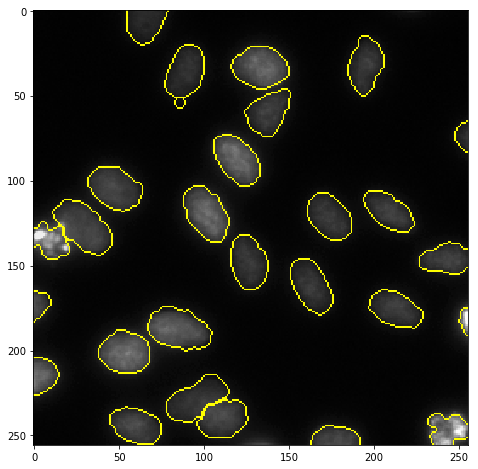

In [17]:
# sanity check
plt.rcParams['figure.figsize'] = (8,8)
image_id = np.random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
plt.imshow(mark_boundaries(utilities.normalize_image(image), utilities.mask_to_label(mask)))
print(class_ids, np.max(image))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1] 255


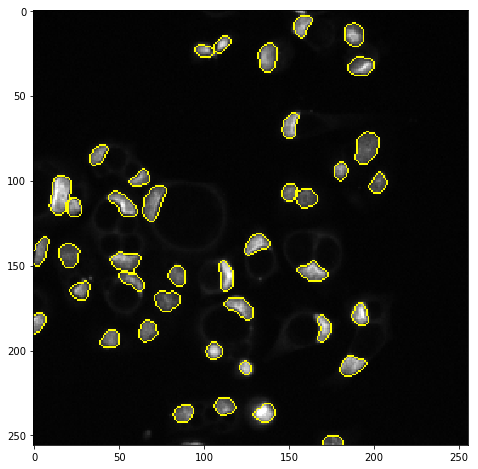

In [20]:
# sanity check
image_id = np.random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
plt.imshow(mark_boundaries(image, utilities.mask_to_label(mask)))
print(class_ids, np.max(image))

## Configuration

In [21]:
class NucleiConfig(Config):

    # Give the configuration a recognizable name
    NAME = "Nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + color nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 384
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 500
    
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_NMS_THRESHOLD = 0.5
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_MAX_INSTANCES = 200
    
    LEARNING_RATE = 0.001
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    WEIGHT_DECAY = 0.0001 # regularization
    
    USE_MINI_MASK = False
    ROI_POSITIVE_RATIO = 0.33
    
    MEAN_PIXEL = [127, 127, 127]
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [127, 127, 127]
MINI_MASK_SHAPE                (56, 56)
NAME                           Nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POS

## Create model

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [17]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='all')

## Load model

In [22]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    RPN_NMS_THRESHOLD = 0.5
    DETECTION_NMS_THRESHOLD = 0.3
    DETECTION_MAX_INSTANCES = 500
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
model_path = os.path.join(MODEL_DIR, 'nuclei20180311T2309', 'mask_rcnn_nuclei_0004.h5')

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\logs_gray\nuclei20180311T2309\mask_rcnn_nuclei_0004.h5


## Evaluate on training data

In [23]:
n_images = 100
mA = []
random.seed(1234)
image_ids = random.sample(dataset_train.image_ids.tolist(), n_images)
for image_id in tqdm(image_ids):
    original_image, _, _, _, gt_mask = modellib.load_image_gt(dataset_train, inference_config, image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    mask = r['masks']
    label = utilities.mask_to_label(mask)
    mask = utilities.label_to_mask(label)
    mA.append(utilities.evaluate(gt_mask, mask))
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.04it/s]


## Evaluate on validation

In [25]:
mA = []
image_ids = dataset_val.image_ids.tolist()
for image_id in tqdm(image_ids):
    original_image, _, _, _, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    mask = r['masks']
    if mask.size:
        label = utilities.mask_to_label(mask)
        mask = utilities.label_to_mask(label)
    mA.append(utilities.evaluate(gt_mask, mask))


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [03:06<00:00,  1.15it/s]


In [26]:
np.mean(mA)

0.609738523773456

In [ ]:
# Test on a random image
image_id = 817
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            ['B','G','C'], figsize=(16, 16))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]

masks = r['masks']
mask_sizes = np.sum(masks, axis=(0,1))
mask_sizes = np.argsort(mask_sizes)[::-1]
masks = masks[:,:,mask_sizes]
label = np.zeros(masks.shape[:2], dtype='uint16')
n_instances = masks.shape[2]
for j in range(n_instances):
    label[masks[:,:,j]!=0] = j+1
masks_trimmed = utilities.label_to_mask(label)

visualize.display_instances(original_image, r['rois'], masks_trimmed, r['class_ids'], ['B','G','C'], r['scores'], ax=get_ax(size=16))

In [ ]:
utilities.evaluate(gt_mask, masks_trimmed)

## test images

In [ ]:
PATH_TEST = 'D:/data/kaggle_dsb_2018/stage1_test/'

## load datasets
images_test = []

image_test_ids = next(os.walk(PATH_TEST))[1]
for i in tqdm(range(len(image_test_ids))):
    image_path = PATH_TEST + image_test_ids[i] + '/' + 'images/' + image_test_ids[i] + '.png'
    image = cv2.imread(image_path)
    images_test.append(image)

In [ ]:
i = 55

results = model.detect([images_test[i]], verbose=1)

r = results[0]


visualize.display_instances(images_test[i], r['rois'], r['masks'], r['class_ids'], ['B','G','C'], ax=get_ax(size=8))

## Detection

In [ ]:
def split_detect_combine(image, size=256):
    
    if image.shape[0]<=size:
        I = [0]
    else:
        I = np.linspace(0, image.shape[0]-size, image.shape[0]//size+1, dtype=int)
    
    if image.shape[1]<=size:
        J = [0]
    else:
        J = np.linspace(0, image.shape[1]-size, image.shape[1]//size+1, dtype=int)

    masks = []
    for i in I:
        for j in J:
            img = image[i:i+size, j:j+size]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            if r['masks'].size:
                mask = np.zeros(image.shape[:2]+r['masks'].shape[2:], dtype=bool)
                mask[i:i+size, j:j+size] = utilities.label_to_mask(utilities.mask_to_label(r['masks']))
                masks.append(mask)
                
    return masks


def mask_to_coordinate(mask):
    coordinate = []
    for slc in range(mask.shape[2]):
        coordinate.append(set(zip(*np.nonzero(mask[:,:,slc]))))
    return coordinate


def coordinate_to_mask(rows, cols, coordinate):
    mask = np.zeros([rows, cols, len(coordinate)], dtype=bool)
    for slc in range(len(coordinate)):
        I, J = zip(*coordinate[slc])
        mask[I,J,slc] = True
    return mask


def merge_masks(masks):
    '''masks is a list'''
    coordinate_merge = [set()]
    for mask in masks:
        coordinate = mask_to_coordinate(mask)
        for coord in coordinate:
            overlap = tuple(map(lambda s: len(s&coord), coordinate_merge))
            ix = np.argmax(overlap)
            if overlap[ix]>0:
                coordinate_merge[ix].update(coord)
            else:
                coordinate_merge.append(coord)
    rows, cols = masks[0].shape[:2]
    return coordinate_to_mask(rows, cols, coordinate_merge[1:])

In [ ]:
new_test_ids = []
rles = []

for i in tqdm(range(len(image_test_ids))):
    
    masks = split_detect_combine(images_test[i], 512)
    mask = merge_masks(masks)
    mask = utilities.label_to_mask(utilities.mask_to_label(mask))
    
    ## exclude outliers
    sizes = np.sum(mask, axis=(0,1))
    keep = np.logical_and(sizes<np.mean(sizes)+3*np.std(sizes), sizes>np.mean(sizes)-3*np.std(sizes))
    mask = mask[:,:,keep]
    
    ## display
    plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(mask)))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

    ## debugging
    assert np.max(np.sum(mask, axis=-1))==1
    assert mask.shape[:2]==images_test[i].shape[:2]
    
    ## encode masks into rles
    for k in range(mask.shape[2]):
        new_test_ids.append(image_test_ids[i])
        rles.append(utilities.rle_to_string(utilities.rle_encode(mask[:,:,k])))


## Write Submission file

In [ ]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = rles
sub.to_csv('sub-dsbowl2018-19.csv', index=False)

In [ ]:
i= 20
masks = split_detect_combine(images_test[i], 256)
mask = merge_masks(masks)
mask = utilities.label_to_mask(utilities.mask_to_label(mask))

## exclude outliers
sizes = np.sum(mask, axis=(0,1))
keep = np.logical_and(sizes<np.mean(sizes)+5*np.std(sizes), sizes>np.mean(sizes)-5*np.std(sizes))
mask = mask[:,:,keep]

## display
plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(mask)))

In [ ]:
def split_detect_combine(image, H=256, W=256):
    n_y, n_x = image.shape[:2]
    N_y = math.ceil(n_y/H)+1
    N_x = math.ceil(n_x/W)+1
    pad_y = N_y*H-n_y
    pad_x = N_x*W-n_x
    image = np.pad(image, [(pad_y//2, pad_y-pad_y//2), (pad_x//2, pad_x-pad_x//2), (0, 0)], 'constant', constant_values=[(0,0)])
    masks = []
    for i in range(0, N_y*H-H//4*3, H//4):
        for j in range(0, N_x*W-W//4*3, W//4):
            img = image[i:i+H, j:j+W]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            if r['masks'].size:
                mask = np.zeros(image.shape[:2]+r['masks'].shape[2:], dtype=bool)
                mask[i:i+H, j:j+W] = r['masks']
                masks.append(mask[pad_y//2:pad_y//2+n_y, pad_x//2:pad_x//2+n_x])
    return masks


def morph_mask(mask, op, element, ksize = 2):
    kernel=cv2.getStructuringElement(element, (ksize, ksize))
    mask = mask.astype('uint8')
    for instance in range(mask.shape[2]):
        mask[:,:,instance] = cv2.morphologyEx(mask[:,:,instance], op, kernel)
    return mask.astype(bool)


def merge_masks(masks):
    '''masks is a list'''
    M = np.sum(np.concatenate(masks, axis=-1), axis=-1)>=4
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    M = cv2.morphologyEx(M.astype('uint8'), cv2.MORPH_OPEN, kernel) 
    # M = cv2.morphologyEx(M, cv2.MORPH_DILATE, kernel)
    M = M.astype(bool)
    
    masks = list(map(lambda mask: mask*np.expand_dims(M, axis=-1), masks))
    masks = list(map(lambda mask: mask[:,:,np.sum(mask, axis=(0,1))!=0], masks))
    coordinate_merge = [set()]
    for mask in masks:
        coordinate = mask_to_coordinate(mask)
        for coord in coordinate:
            overlap = tuple(map(lambda s: len(s&coord), coordinate_merge))
            ix = np.argmax(overlap)
            if overlap[ix]>0:
                coordinate_merge[ix].update(coord)
            else:
                coordinate_merge.append(coord)
    rows, cols = masks[0].shape[:2]
    return coordinate_to_mask(rows, cols, coordinate_merge[1:])


def merge_mask(mask):
    all_hits = np.sum(mask, axis=-1)>=3
    mask = mask * np.expand_dims(all_hits, axis=-1)
    sizes = np.sum(mask, axis=(0,1))
    keep = sizes!=0
    mask = mask[:,:,keep]
    sizes = sizes[keep]
    mask = mask[:,:,np.argsort(sizes)[::-1]]
    
    coordinate = mask_to_coordinate(mask)
    coordinate_merge = []
    
    for i in range(len(coordinate)):
        for coord in coordinate_merge:
            if len(coordinate[i] & coord)/len(coordinate[i]) >= 0.5:
                break
        else:
            coordinate_merge.append(coordinate[i])
    rows, cols = mask.shape[:2]
    return coordinate_to_mask(rows, cols, coordinate_merge)


def merge_mask(mask):
    
    sizes = np.sum(mask, axis=(0,1))
    keep = sizes!=0
    mask = mask[:,:,keep]
    
    sizes = sizes[keep]
    mask = mask[:,:,np.argsort(sizes)[::-1]] # maybe optional
    
    coordinate = mask_to_coordinate(mask)
    
    ix_include = set()
    ix_exclude = set()
    for i in range(len(coordinate)):
        if i not in ix_exclude:
            j_exclude = set()
            for j in range(i+1, len(coordinate)):
                if j not in ix_exclude:
                    iou = len(coordinate[i]&coordinate[j])/len(coordinate[i]|coordinate[j])
                    if iou>0.5:
                        j_exclude.add(j)
            if len(j_exclude)>=8:
                ix_include.add(i)
                ix_exclude.update(j_exclude)
                        
    return mask[:,:,list(ix_include)]
                    
    


def exclude_outliers(mask, dev):
    sizes = np.sum(mask, axis=(0,1))
    median = np.median(sizes)
    mad = np.mean(np.abs(sizes-median))
    
    keep = np.logical_and(median-dev*mad<sizes, sizes<median+dev*mad)
    mask = mask[:,:,keep]
    return mask

In [ ]:
i= 54
masks = split_detect_combine(images_test[i], 256)

In [ ]:
mask = np.concatenate(masks, axis=-1)
mask_merge = merge_mask(mask)


In [ ]:
mask_part = mask[25:75, 120:150]
mask_part = mask_part[:, :, np.sum(mask_part, axis=(0,1))!=0]
mask_part_merge = merge_mask(mask_part)


In [ ]:
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(mask_merge))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(mask_merge)))

In [ ]:
mask_part = mask[90:110, 40:80]
sizes = np.sum(mask_part, axis=(0,1))
mask_part = mask_part[:,:,sizes!=0]
coor = mask_to_coordinate(mask_part)

In [ ]:
iou = np.zeros([len(coor), len(coor)])
for i in range(len(coor)):
    for j in range(i, len(coor)):
        iou[i,j] = len(coor[i] & coor[j])/len(coor[i] | coor[j])

In [ ]:
iou[1,:]

In [ ]:
plt.imshow(np.sum(mask_part, axis=-1))

In [ ]:
plt.imshow(mask_part[:,:,6])

In [ ]:
mask_part_merge = merge_mask(mask_part)

In [ ]:
plt.imshow(mask_part_merge[:,:,3])

In [ ]:
plt.imshow(np.sum(mask_part, axis=-1))

In [ ]:
plt.imshow(mask_merge[:,:,3])

In [ ]:
plt.imshow(mark_boundaries(images_test[i][250:350, 400:500], utilities.mask_to_label(mask_final)))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(mask_final))
plt.subplot(1,2,2)
plt.imshow(images_test[i][250:350, 400:500])

In [ ]:
mask_part = mask[250:350, 400:500]
mask_part = mask_part[:,:,np.sum(mask_part, axis=(0,1))!=0]

In [ ]:
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(mask_part))
plt.subplot(1,2,2)
plt.imshow(mask_part[:,:,12])

In [ ]:
plt.imshow(utilities.mask_to_label(masks[15]))

In [ ]:
np.sum(mask_final, axis=(0,1))

In [ ]:
tmp = morph_mask(np.concatenate(masks, axis=-1), cv2.MORPH_OPEN, cv2.MORPH_RECT)

In [ ]:
plt.rcParams['figure.figsize'] = (16,16)
plt.subplot(1,2,1)
plt.imshow(np.sum(tmp, axis=-1))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
tmp = np.sum(np.concatenate(masks, axis=-1), axis=-1)>=3

In [ ]:
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
mask_morph = cv2.morphologyEx(tmp.astype('uint8'), cv2.MORPH_OPEN, kernel) 
mask_morph = cv2.morphologyEx(mask_morph, cv2.MORPH_DILATE, kernel)

In [ ]:
kernel

In [ ]:
plt.subplot(1,2,1)
plt.imshow(mask_morph)
plt.subplot(1,2,2)
plt.imshow(tmp)

In [ ]:
mask = merge_masks(masks)

In [ ]:
plt.rcParams['figure.figsize'] = (16,16)
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(mask))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
import time
from IPython import display

plt.rcParams['figure.figsize'] = (8,8)
for i in range(len(images_test)):
    masks = split_detect_combine(images_test[i], 256, 256)
    plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(masks)))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2.0)

In [ ]:
i=64
masks = split_detect_combine(images_test[i], 256, 256)
plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(masks)))


In [ ]:
def exclude_outlier(x, dev, one_side):
    m = np.mean(x)
    d = np.std(x)
    if one_side:
        keep = x<m+dev*d
    else:
        keep = np.logical_and(x<m+dev*d, x>m-dev*d)
    return keep

In [ ]:
new_test_ids = []
rles = []

for i in range(len(image_test_ids)):
    
    img = images_test[i]

    if np.all(img[:,:,0]==img[:,:,1]):
        results = model.detect([img], verbose=0)
    else:
        results = model.detect([255-img], verbose=0)

    r = results[0]

    masks = r['masks'].astype(bool)
    mask_sizes = np.sum(masks, axis=(0,1))
    keep1 = exclude_outlier(mask_sizes, 2, False)

    if not np.all(img[:,:,0]==img[:,:,1]):
        intensities = np.zeros(masks.shape[2], dtype=float)
        for j in range(masks.shape[2]):
            intensities[j] = np.mean(img[masks[:,:,j]])
        keep2 = exclude_outlier(intensities, 2, True)
    else:
        keep2 = np.ones_like(keep1, dtype=bool)

    keep = np.logical_and(keep1, keep2)

    masks = r['masks'][:,:,keep].astype(bool)
    mask_sizes = np.sum(masks, axis=(0,1))
    masks = masks[:,:,np.argsort(mask_sizes)[::-1]]
    label = np.zeros(masks.shape[:2], dtype='uint16')
    n_instances = masks.shape[2]
    for j in range(n_instances):
        label[masks[:,:,j]!=0] = j+1
    masks_trimmed = utilities.label_to_mask(label)  
    
    plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(masks_trimmed)))
    plt.title(str(i))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2.0)
    
    ## encode masks into rles
    for k in range(masks_trimmed.shape[2]):
        new_test_ids.append(image_test_ids[i])
        rles.append(utilities.rle_to_string(utilities.rle_encode(masks_trimmed[:,:,k])))


## Detection

In [ ]:
new_test_ids = []
rles = []

for i in range(len(image_test_ids)):
    
    if np.all(images_test[i][:,:,0]==images_test[i][:,:,1]):
        results = model.detect([images_test[i]], verbose=0)
    else:
        results = model.detect([255-images_test[i]], verbose=0)

    r = results[0]
    r = results[0]
    sizes = np.apply_along_axis(lambda x: (x[2]-x[0])*(x[3]-x[1]), 1, r['rois']) # roi is (y1, x1, y2, x2)
    keep = sizes<5*np.median(sizes)
    
    ## deal with overlapping masks
#     masks = r['masks'][..., keep]
#     image = np.sum(masks, axis=-1)>0
#     local_maxi = centroids(masks)
#     markers = morphology.label(local_maxi)
#     labels_ws = watershed(image, markers, mask=image)
#     masks_trimmed = utilities.label_to_mask(labels_ws)

    masks = r['masks'][...,keep]
    mask_sizes = np.sum(masks, axis=(0,1))
    mask_sizes = np.argsort(mask_sizes)[::-1]
    masks = masks[:,:,mask_sizes]
    label = np.zeros(masks.shape[:2], dtype='uint16')
    n_instances = masks.shape[2]
    for j in range(n_instances):
        label[masks[:,:,j]!=0] = j+1
    masks_trimmed = utilities.label_to_mask(label)

    ## debugging
    assert np.max(np.sum(masks_trimmed, axis=-1))==1
    
    ## encode masks into rles
    for k in range(masks_trimmed.shape[2]):
        new_test_ids.append(image_test_ids[i])
        rles.append(utilities.rle_to_string(utilities.rle_encode(masks_trimmed[:,:,k])))


## Write to submission file

In [ ]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = rles
sub.to_csv('sub-dsbowl2018-14.csv', index=False)

In [ ]:
len(rles)

In [ ]:
images_test[i].dtype

In [ ]:
def exclude_outlier(x, dev, one_side):
    m = np.mean(x)
    d = np.std(x)
    if one_side:
        keep = x<m+dev*d
    else:
        keep = np.logical_and(x<m+dev*d, x>m-dev*d)
    return keep

In [ ]:
intensities

In [ ]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    DETECTION_MAX_INSTANCES = 500

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
def nms_mask(mask, threshold = 0.8):
    mask_sizes = np.sum(mask, axis=(0,1))
    pick = []
    ix = np.argsort(mask_sizes)
    for i in tqdm(range(len(ix))):
        for j in range(i+1, len(ix)):
            if np.sum(np.logical_and(mask[:,:,ix[i]], mask[:,:,ix[j]]))/np.sum(mask[:,:,ix[i]])>threshold:
                break
        else:
            pick.append(ix[i])
    return pick

In [ ]:
def nms_mask(mask, threshold = 0.8):
    coordinates = []
    mask_sizes = []
    for slc in range(mask.shape[2]):
        I, J = np.nonzero(mask[:,:,slc])
        coordinates.append(set(zip(I, J)))
        mask_sizes.append(len(I))
    ix = np.argsort(mask_sizes)
    pick = []
    for i in range(len(ix)):
        for j in range(i+1, len(ix)):
            if len(coordinates[ix[i]] & coordinates[ix[j]])/len(coordinates[ix[i]]) > threshold:
                break
        else:
            pick.append(ix[i])
    return pick

In [ ]:
def split_detect_combine(image, size=256):
    
    if image.shape[0]<=size:
        I = [0]
    else:
        I = np.linspace(0, image.shape[0]-size, image.shape[0]//size+1, dtype=int)
    
    if image.shape[1]<=size:
        J = [0]
    else:
        J = np.linspace(0, image.shape[1]-size, image.shape[1]//size+1, dtype=int)

    masks = []
    for i in I:
        for j in J:
            img = image[i:i+size, j:j+size]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            if r['masks'].size:
                mask = np.zeros(image.shape[:2]+r['masks'].shape[2:], dtype=bool)
                mask[i:i+size, j:j+size] = utilities.label_to_mask(utilities.mask_to_label(r['masks']))
                masks.append(mask)
                
    return masks


def mask_to_coordinate(mask):
    coordinate = []
    for slc in range(mask.shape[2]):
        coordinate.append(set(zip(*np.nonzero(mask[:,:,slc]))))
    return coordinate


def coordinate_to_mask(rows, cols, coordinate):
    mask = np.zeros([rows, cols, len(coordinate)], dtype=bool)
    for slc in range(len(coordinate)):
        I, J = zip(*coordinate[slc])
        mask[I,J,slc] = True
    return mask


def merge_masks(masks):
    '''masks is a list'''
    coordinate_merge = [set()]
    for mask in masks:
        coordinate = mask_to_coordinate(mask)
        for coord in coordinate:
            overlap = tuple(map(lambda s: len(s&coord), coordinate_merge))
            ix = np.argmax(overlap)
            if overlap[ix]>0:
                coordinate_merge[ix].update(coord)
            else:
                coordinate_merge.append(coord)
    rows, cols = masks[0].shape[:2]
    return coordinate_to_mask(rows, cols, coordinate_merge[1:])

In [ ]:
i = 11
masks = split_detect_combine(images_test[i])
mask = merge_masks(masks)

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
plt.imshow(mark_boundaries(images_test[i], utilities.mask_to_label(mask)))

In [ ]:
def split_detect_combine(image, H=256, W=256):
    n_y, n_x = image.shape[:2]
    N_y = math.ceil(n_y/H)
    N_x = math.ceil(n_x/W)
    pad_y = N_y*H-n_y
    pad_x = N_x*W-n_x
    image = np.pad(image, [(pad_y//2, pad_y-pad_y//2), (pad_x//2, pad_x-pad_x//2), (0, 0)], 'constant', constant_values=[(0,0)])
    masks = []
    for i in range(N_y):
        for j in range(N_x):
            img = image[i*H:(i+1)*H, j*W:(j+1)*W]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            if r['masks'].size:
                mask = np.zeros(image.shape[:2]+r['masks'].shape[2:], dtype=bool)
                mask[i*H:(i+1)*H, j*W:(j+1)*W] = utilities.label_to_mask(utilities.mask_to_label(r['masks']))
                masks.append(mask[pad_y//2:pad_y//2+n_y, pad_x//2:pad_x//2+n_x])
    return np.concatenate(masks, axis=-1)

In [ ]:
i = 31
masks_ = split_detect_combine(images_test[i], 256, 256)

In [ ]:
plt.rcParams['figure.figsize'] = (15,15)
plt.subplot(1,2,1)
#plt.imshow(utilities.mask_to_label(masks_))
plt.imshow(np.sum(masks_, axis=-1))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
i = 36
mask_, num_hits = split_detect_combine(images_test[i])

In [ ]:
mask_ = np.logical_and(mask_, np.expand_dims(np.sum(mask_, axis=-1)/num_hits==1, axis=-1))

In [ ]:
mask_ = mask_[:,:,np.sum(mask_, axis=(0,1))!=0]

In [ ]:
pick = nms_mask(mask_, 0.5)

In [ ]:
plt.subplot(1,2,1)
# plt.imshow(np.sum(mask_[:,:,pick], axis=-1))
plt.imshow(utilities.mask_to_label((mask_[:,:,pick])))
plt.subplot(1,2,2)
plt.imshow(images_test[i])


In [ ]:
plt.imshow(np.sum(mask_, axis=-1))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.sum(mask_, axis=-1)/num_hits==1)
plt.subplot(1,2,2)
plt.imshow(images_test[i])


In [ ]:
from functools import reduce
def split_detect_combine(image, size=256):
    
    if image.shape[0]<=size:
        I = [0]
    else:
        I = np.linspace(0, image.shape[0]-size, image.shape[0]//size+1, dtype=int)
    
    if image.shape[1]<=size:
        J = [0]
    else:
        J = np.linspace(0, image.shape[1]-size, image.shape[1]//size+1, dtype=int)
    
    print(I)
    print(J)
    masks = []
    for i in I:
        for j in J:
            img = image[i:i+size, j:j+size]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            mask = np.zeros(image.shape[:2]+r['masks'].shape[2:], dtype=bool)
            mask[i:i+size, j:j+size] = utilities.label_to_mask(utilities.mask_to_label(r['masks']))
            masks.append(mask)
    
    def merge(msk1, msk2):
        msk = np.concatenate([msk1, msk2], axis=-1)
        pick = nms_mask(msk, 0.5)
        return msk[:,:,pick]
    
    return reduce(merge, masks)

In [ ]:
i = 20
masks_ = split_detect_combine(images_test[i])

In [ ]:
plt.rcParams['figure.figsize'] = (16,16)
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(masks_))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
plt.imshow()

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.sum(masks_, axis=-1))
plt.subplot(1,2,2)
plt.imshow(utilities.mask_to_label(masks_))

In [ ]:
plt.rcParams['figure.figsize'] = (16,16)
plt.subplot(1,3,1)
plt.imshow(utilities.mask_to_label(masks_[0]))
plt.subplot(1,3,2)
plt.imshow(utilities.mask_to_label(masks_[1]))
tmp_ = np.concatenate(masks_[:2], axis=-1)
pick = nms_mask(tmp_, threshold=0.5)
plt.subplot(1,3,3)
plt.imshow(utilities.mask_to_label(tmp_[:,:,pick]))

In [ ]:
i = 49
mask_ = split_detect_combine(images_test[i])
plt.rcParams['figure.figsize'] = (10,10)
plt.subplot(1,2,1)
plt.imshow(np.sum(mask_, axis=-1))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
pick = nms_mask(mask_, threshold=0.5)

In [ ]:
plt.rcParams['figure.figsize'] = (16,16)
plt.subplot(1,2,1)
plt.imshow(utilities.mask_to_label(mask_))
plt.subplot(1,2,2)
plt.imshow(images_test[i])

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
i = 10

img = images_test[i][:256,:256]

if np.all(img[:,:,0]==img[:,:,1]):
    results = model.detect([img], verbose=0)
else:
    results = model.detect([255-img], verbose=0)

r = results[0]


plt.subplot(1,2,1)
plt.imshow(img)

mask = utilities.label_to_mask(utilities.mask_to_label(r['masks']))


visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], ['',''], ax=get_ax())

In [ ]:
plt.imshow(np.sum(r['masks'], axis=-1))

In [ ]:
def split_detect_merge(image, size=256):
    
    label = np.zeros(image.shape[:2], dtype=np.uint16)
    n_instances = 0
    for i in range(0, image.shape[0], size):
        for j in range(0, image.shape[1], size):
            
            img = image[i:i+256, j:j+256]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            msk = r['masks'].astype(bool)
            lbl = utilities.mask_to_label(msk)
            lbl[lbl!=0] = lbl[lbl!=0]+n_instances
            label[i:i+256, j:j+256] = lbl
            n_instances += msk.shape[2]
    return label

In [ ]:
def split_detect(image, size=256):
    masks = []
    n_instances = 0
    for i in range(0, image.shape[0], size):
        for j in range(0, image.shape[1], size):
            
            img = image[i:i+256, j:j+256]
            if np.all(img[:,:,0]==img[:,:,1]):
                res = model.detect([img], verbose=0)
            else:
                res = model.detect([255-img], verbose=0)
            r = res[0]
            masks.append(r['masks'].astype(bool))
    return masks

In [ ]:
masks_ = split_detect(images_test[i])

In [ ]:
plt.imshow(np.sum(masks_[3], axis=-1))

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
plt.subplot(1,2,1)
plt.imshow(images_test[i])
plt.subplot(1,2,2)
plt.imshow(label_)
print(label_.shape, images_test[i].shape)

In [ ]:
i = 20

img = images_test[i][256:,:256]

if np.all(img[:,:,0]==img[:,:,1]):
    results = model.detect([img], verbose=0)
else:
    results = model.detect([255-img], verbose=0)

r = results[0]

masks = r['masks'].astype(bool)
mask_sizes = np.sum(masks, axis=(0,1))
keep1 = exclude_outlier(mask_sizes, 5, False)

if not np.all(img[:,:,0]==img[:,:,1]):
    intensities = np.zeros(masks.shape[2], dtype=float)
    for j in range(masks.shape[2]):
        intensities[j] = np.mean(img[masks[:,:,j]])
    keep2 = exclude_outlier(intensities, 5, True)
else:
    keep2 = np.ones_like(keep1, dtype=bool)
        
# keep = np.logical_and(keep1, keep2)
keep = np.ones_like(keep1, dtype=bool)

plt.subplot(1,2,1)
plt.imshow(img)

masks = r['masks'][:,:,keep].astype(bool)
mask_sizes = np.sum(masks, axis=(0,1))
masks = masks[:,:,np.argsort(mask_sizes)[::-1]]
label = np.zeros(masks.shape[:2], dtype='uint16')
n_instances = masks.shape[2]
for j in range(n_instances):
    label[masks[:,:,j]!=0] = j+1
masks_trimmed = utilities.label_to_mask(label)


visualize.display_instances(img, r['rois'], masks_trimmed, r['class_ids'], ['',''], ax=get_ax())

In [ ]:
plt.imshow(np.sum(r['masks'][:,:,pick], axis=-1))

In [ ]:
plt.imshow(np.sum(masks, axis=-1))

In [ ]:
tmp_ = np.zeros(masks.shape[2])
for j in range(masks.shape[2]):
    tmp_[j] = np.max(np.sum(masks, axis=-1)[masks[:,:,j]])

In [ ]:
r['masks'].shape

In [ ]:
pick = utils.non_max_suppression()

In [ ]:
i = 5
plt.subplot(1,2,1)
plt.imshow(images_test[i])

if np.all(images_test[i][:,:,0]==images_test[i][:,:,1]):
    results = model.detect([images_test[i]], verbose=0)
else:
    results = model.detect([255-images_test[i]], verbose=0)
r = results[0]


masks = r['masks']
mask_sizes = np.sum(masks, axis=(0,1))
keep = np.logical_and(mask_sizes<5*np.median(mask_sizes), mask_sizes>np.median(mask_sizes)/5)


sizes = np.apply_along_axis(lambda x: (x[2]-x[0])*(x[3]-x[1]), 1, r['rois']) # roi is (y1, x1, y2, x2)
keep = np.logical_and(sizes<5*np.median(sizes), sizes>np.median(sizes)/5)

# masks = r['masks'][..., keep]
# image = np.sum(masks, axis=-1)>0
# local_maxi = centroids(masks)
# markers = morphology.label(local_maxi)
# labels_ws = watershed(image, markers, mask=image)
# masks_trimmed = utilities.label_to_mask(labels_ws)
masks = r['masks'][...,keep]
mask_sizes = np.sum(masks, axis=(0,1))
mask_sizes = np.argsort(mask_sizes)[::-1]
masks = masks[:,:,mask_sizes]
label = np.zeros(masks.shape[:2], dtype='uint16')
n_instances = masks.shape[2]
for j in range(n_instances):
    label[masks[:,:,j]!=0] = j+1
masks_trimmed = utilities.label_to_mask(label)


visualize.display_instances(images_test[i], r['rois'][keep], masks_trimmed, r['class_ids'][keep], ['',''], ax=get_ax())

In [ ]:
import os

In [ ]:
PATH_TRAIN = 'D:/data/kaggle_dsb_2018/stage1_train/'

## load datasets
images_train = []
masks_train = []

image_train_ids = next(os.walk(PATH_TRAIN))[1]

In [ ]:
image_train_ids[]

In [ ]:
def centroids(masks):
    rows, cols, instances = masks.shape
    local_maxi = np.zeros([rows, cols], dtype=bool)
    for k in range(instances):
        BW = masks[:,:,k]
        I, J = np.nonzero(BW)
        i, j = int(np.mean(I)), int(np.mean(J))
        local_maxi[i,j] = True
    return local_maxi

# test
masks = r['masks'][...,keep]
local_maxi = centroids(masks)

In [ ]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from scipy import ndimage as ndi

masks = r['masks'][...,keep]
image = np.sum(masks, axis=-1)>0
distance = ndi.distance_transform_edt(image)
local_maxi = centroids(masks)
markers = morphology.label(local_maxi)
labels_ws = watershed(image, markers, mask=image)

In [ ]:
plt.imshow(labels_ws)

In [ ]:
def label_to_masks(labels):
    n_instances = np.max(labels)
    masks = np.zeros(labels.shape+(n_instances,), dtype=bool)
    for k in range(n_instances):
        masks[:,:,k] = labels==(k+1)
    return masks

In [ ]:
masks_trimmed = label_to_masks(labels_ws)

In [ ]:
visualize.display_instances(images_test[i], r['rois'][keep], masks_trimmed, r['class_ids'][keep], 
                            dataset_val.class_names, r['scores'][keep], ax=get_ax())

## RLE Routines

In [ ]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle


def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


def rle_decode(rle_str, mask_shape, mask_dtype):
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape[::-1]).T

In [ ]:
rle_to_string(rle_encode(masks_trimmed[:,:,2]))